# Função para buscar dados

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [2]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)

    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")

    return pd.read_csv(Path("datasets/housing/housing.csv"))
    
housing = load_housing_data()

.head Atributos das 10 primeiras linhas:

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


.info Rápida descroção dos dados

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Descobrir o quais categorias existem e quantas regioes pertencem a cada categoria

In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Mostra o resumo dos atributos numéricos

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


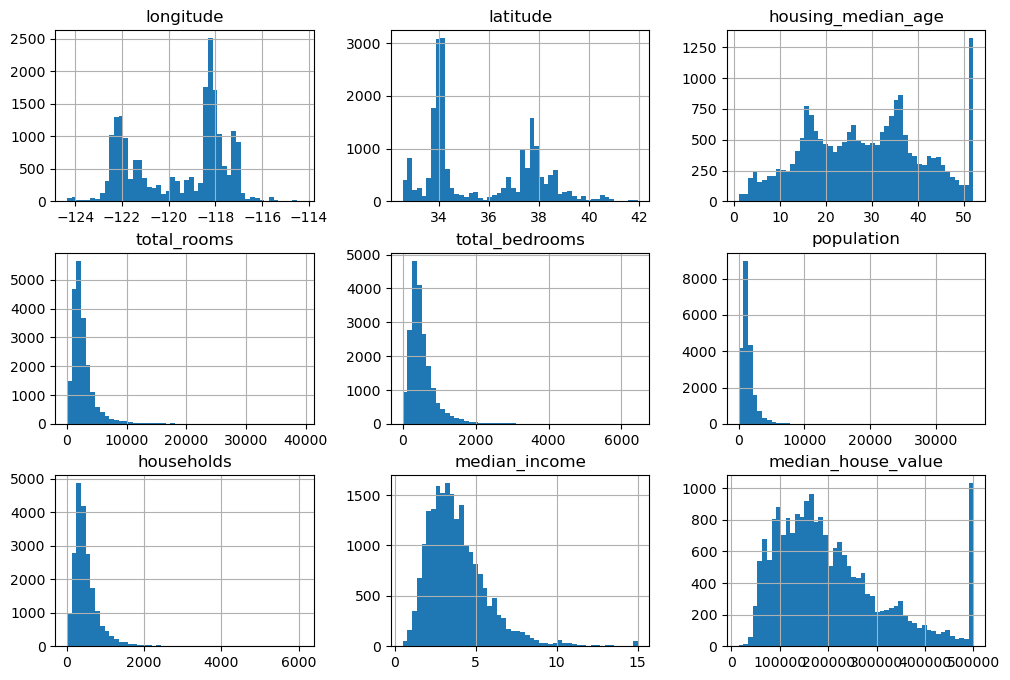

In [8]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12, 8))
plt.show()


# Criando conjunto de dados de teste

## Jeito mais simples
Ideia: Embaralha os indices aleatoriamente e pega os 20% para teste e o resto para treino.

In [9]:
import numpy as np
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [11]:
len(test_set)

4128

### Problemas dessa abordagem: toda vez que executar o programa terá um conjunto novo
Isso pode causar Data Snooping pois ao executar muitas vezes o modelo vai acabar vendo todos os dados

## Método com identificadores:
Usar um identificador exclusivo para cada instancia a fim de decidir se deve ou não fazer parte do conjunto de teste.

Utilizar a função crc32 para criar uma identidade digital única para cada linha baseada em um ID

*Muitas vezes as tabelas não tem um ID fixo se utilizar o indice das linhas e depois acabar deletando alguma pode bagunçar tudo*



In [12]:
from zlib import crc32
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

Utilizando a longitude e latitude da casa para descidir se o dado vai para o conjunto de teste ou de treino. Mesmo que o dado mude de posição ou adicione mais dados a latitude e a longitude não vão mudar, garantindo a integridade da avaliação.

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

# Amostragem estratificada com base na renda

Como a Renda Mediana é muito importante para prever o preço da casa, e necessário garantir que o Teste e o Treino tenham a mesma proporção refletindo a realidade.

In [15]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

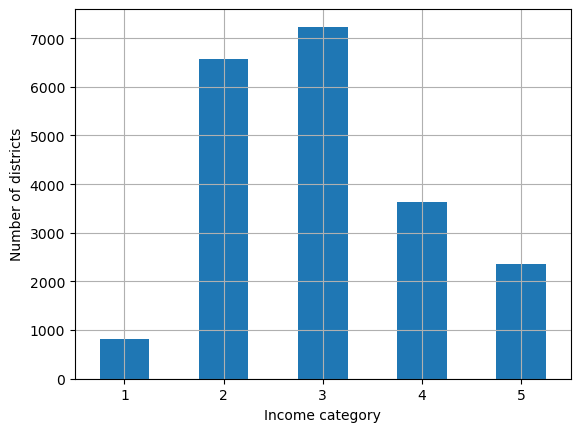

In [17]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()


Divide os dados em 80% de treinamento e 20% de teste respeitando as proporçoes da coluna *income_cat*

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [19]:
strat_train_set, strat_test_set = strat_splits[0]

In [20]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42
)

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [22]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Explorar e visualizar dados

Cópia do conjunto de treinamento original

In [23]:
housing = strat_train_set.copy() 

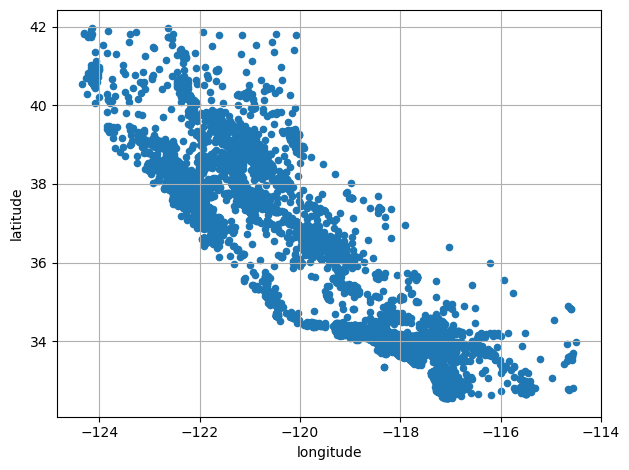

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

Para uma mrelhor visualização:

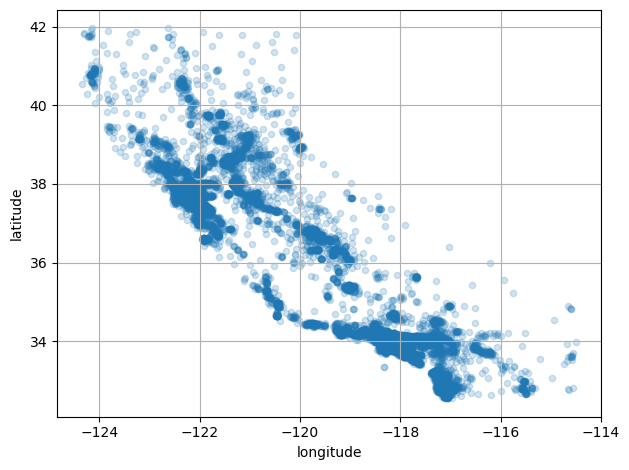

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("Visualizacao_adequada")
plt.show()

Preços dos imoveis em *cmap=jet* que deixa os preços baixos com tons azulados e preços altos com tons avermelhados, quanto maior o circulo indica que a áreas com maior população

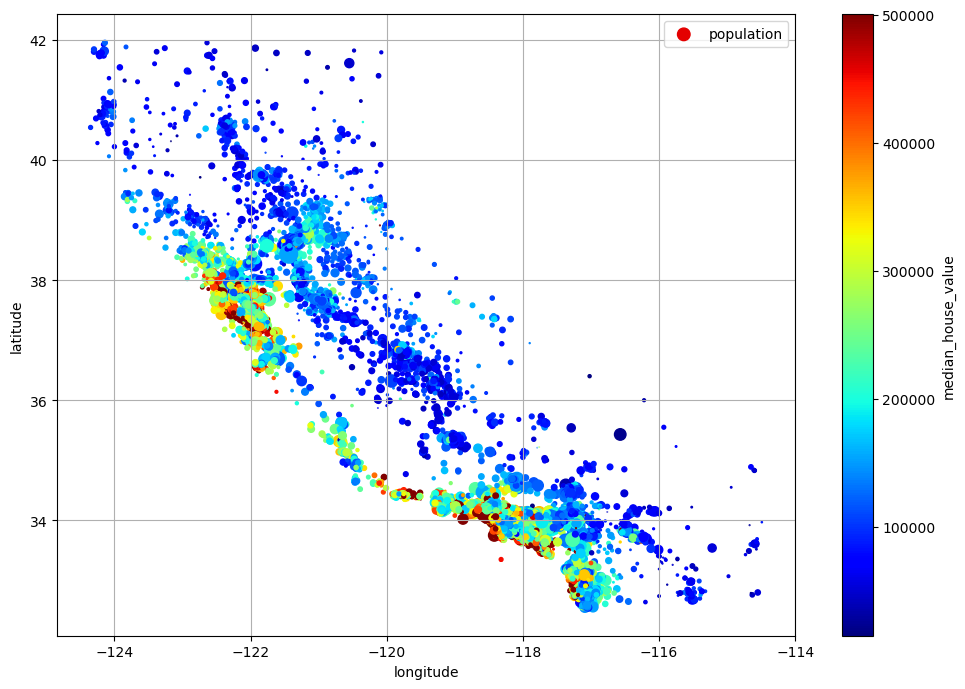

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100,
             label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True,
             sharex=False, figsize=(10, 7))
save_fig("Visualizacao_completa")
plt.show()

### Buscando correlação
Por se tratar de uma quantidade modesta de dados é possivel facilmente encontara o coeficiente de corrlação padrão (r de Person)

In [35]:
corr_matrix = housing.corr(numeric_only=True)

corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

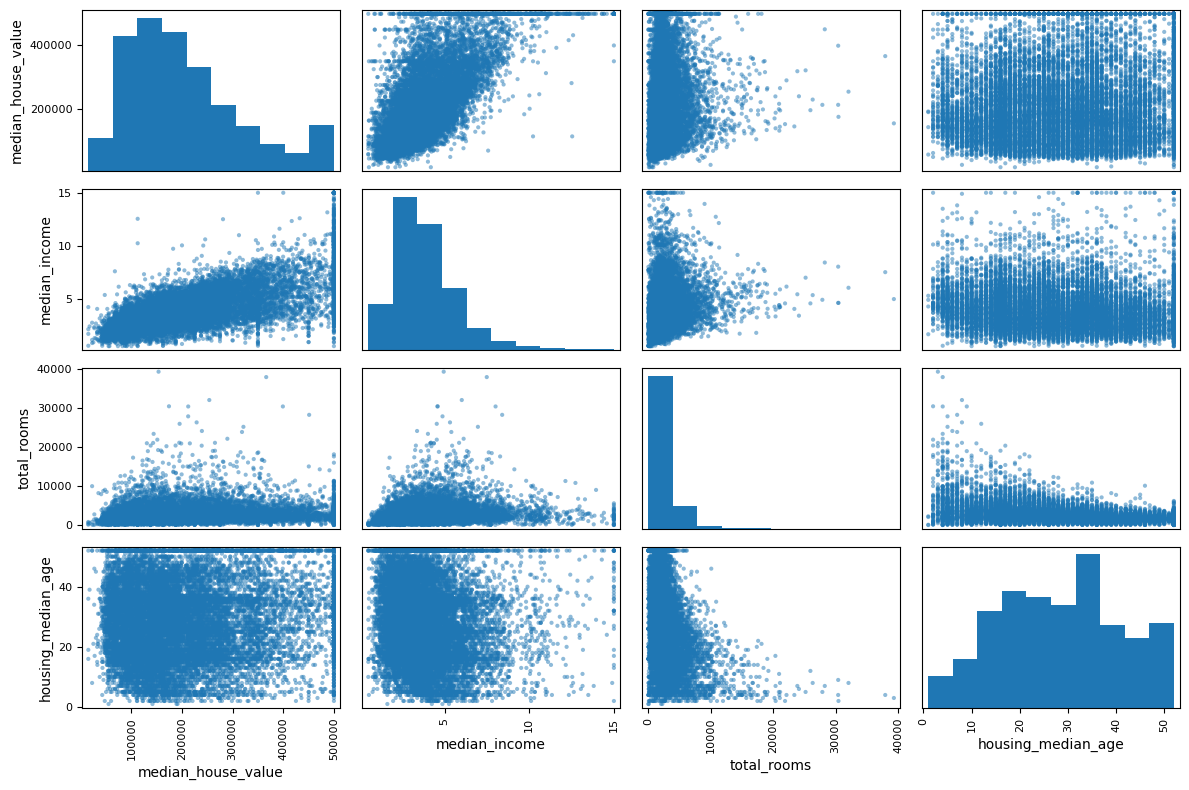

In [37]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("Matriz_de_dispersao")
plt.show()

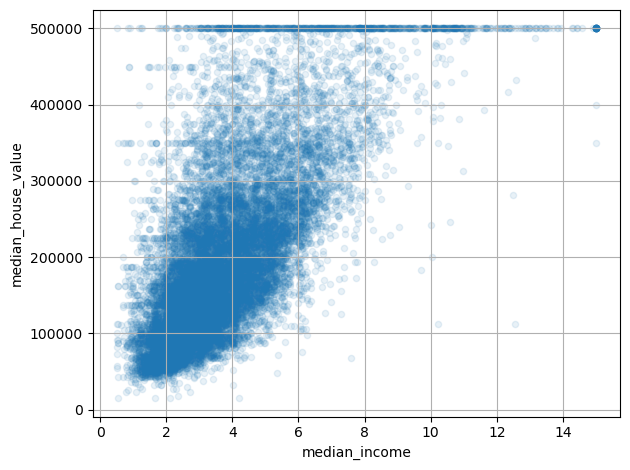

In [38]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
save_fig("Renda_vs_Valor_das_casas")
plt.show()

### Teste combinações de atributos
Criar novos atributos a partir de atributos conhecidos que tenham uma coprrelação
Exemnplo:Cômodos por Domicílio = total_rooms / households

Quartos por Cômodo = total_bedrooms / total_rooms (Essa é a relação entre quartos e cômodos que você anotou, mas deu o nome errado).

População por Domicílio = population / households

In [40]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["pepople_per_house"] = housing["population"] / housing["households"]

In [41]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
pepople_per_house    -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Preparando os dados para o algoritmo de ML

In [42]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Limpeza dos dados
Tratamneto do *total_bedroom*, falta alguns valores para esse atributo assim temos 3 opçoes para arrumar isso:
1. Abrir mão das regiões correspondentes.
2. Abrir mão do atributo inteiro.
3. Definir os valores para algum valor (zero, média, mediana etc.). Isso se chama imputação.

In [45]:
housing.dropna(subset=["total_bedrooms"], inplace=True) #opção 1
housing.drop("total_bedrooms", axis=1) #opção 2
median = housing["total_bedrooms"].median() #opção 3
housing["total_bedrooms"].fillna(median, inplace=True)

/tmp/ipykernel_1504/687647406.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True)


Outra forma de fazer a opção 3 utilizando  *SimpleImputer* que ela armazenará o valor médio de cada característica: isso possibilitará imputar os valores ausentes não apenas no conjunto de treinamento, mas também no conjunto de validação, no conjunto de teste e em qualquer novo dado fornecido ao modelo.

In [47]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [48]:
housing_num = housing.select_dtypes(include=[np.number])

In [49]:
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [50]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [51]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [52]:
X = imputer.transform(housing_num)

Os valores ausentes também podem ser substituídos pelo valor médio (strategy=”mean”), pelo valor mais frequente (strategy=”most_frequent”) ou por um valor constante (strategy= “constant”, fill_value=…). As duas últimas estratégias suportam dados não numéricos.

In [54]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

### Manipulando atrinbutos de texto e categóricos